In [ ]:
from helper_interp import (
    create_model, create_optimizer, train_model, 
    setup_data, plot_training_history,
    visualize_network_architecture, visualize_sample_digits, visualize_prediction,
    plot_activations, get_sample_by_digit, get_sample_by_index,
    train_probe, visualize_probe_weights, compare_probes_across_layers
)
import matplotlib.pyplot as plt

# Interpreting Neural Networks

## The Black Box Problem

Neural networks are incredibly powerful. They can recognise faces, translate languages, drive cars, and even write essays. But here's the uncomfortable truth: **we often don't know how they actually work inside.**

Imagine you built a robot that could perfectly identify cats in photos. You show it a picture, and it says "cat" or "not cat" with 99% accuracy. Amazing! But when someone asks you, "How does it know?", you'd have to say... "I'm not sure." The robot is a **black box** - we can see what goes in and what comes out, but the middle is a mystery.

This is one of the central dilemmas of modern AI. We're deploying systems that make decisions about:
- Who gets a loan
- What medical treatment you receive  
- Whether a self-driving car should brake or swerve
- What content you see on social media

And yet, we can't fully explain *why* these systems make the choices they do.

## Why Does This Matter?

When AI systems fail, the consequences can be serious:
- A hiring algorithm might discriminate against certain groups without anyone realising
- A medical AI might miss a diagnosis for reasons no one can identify
- A content recommendation system might radicalise users through paths we can't trace

If we can't look inside these systems and understand them, how can we trust them? How can we fix them when they go wrong? How can we ensure they're fair?

## Mechanistic Interpretability: Opening the Black Box

This is where **mechanistic interpretability** comes in. It's a field of AI safety research that tries to reverse-engineer neural networks - to figure out what the different parts are actually doing.

In this activity, you'll:
1. **Train** a simple neural network to recognise handwritten digits (0-9)
2. **Peer inside** to see what happens at each layer as data flows through
3. **Probe** the network to discover what concepts it has secretly learned

By the end, you'll have hands-on experience with one of the most important challenges in AI safety: understanding what's really going on inside the machines we build.

Let's open the black box.

## 1. Training the Neural Network

In [ ]:
# Load the MNIST data and create dataloaders
train_images, train_labels, test_images, test_labels, train_loader, test_loader = setup_data()

### Visualizing Input Digits

Each MNIST digit is a 28x28 pixel grayscale image. But neural networks don't understand 2D images directly - they need a **vector** (a list of numbers).

**How do we convert an image to a vector?**

We **flatten** the 2D grid into a 1D list by reading the pixels row by row. Each pixel is a number from 0 (black) to 255 (white). We also **normalise** these values by dividing by 255, so they range from 0 to 1. This helps the neural network learn more effectively. The network will learn on its own which pixels tend to appear together - we don't need to preserve the 2D structure explicitly.

Think about the pros and cons of doing this? How could we improve this approach?

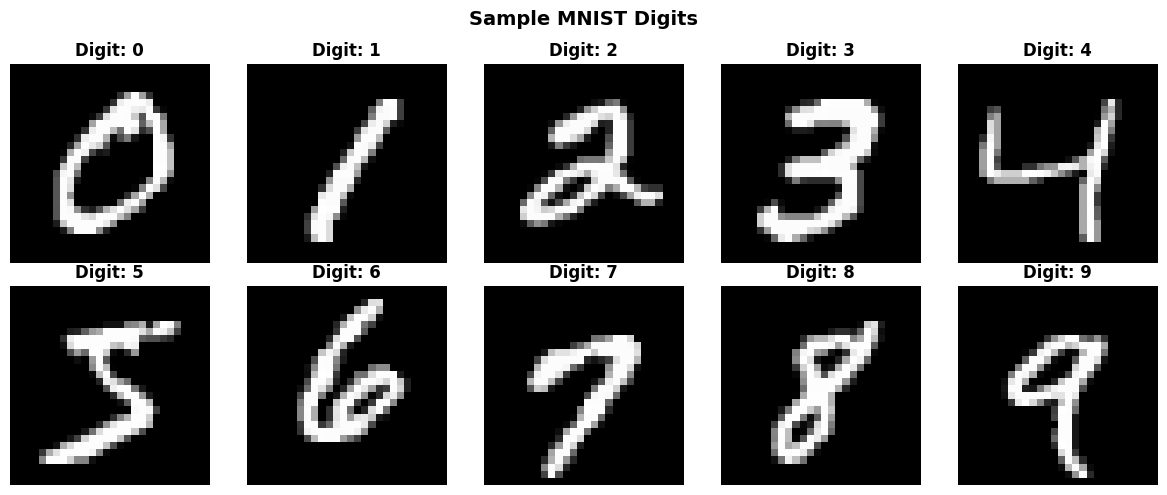

In [4]:
# run this cell in order to visualize the images
visualize_sample_digits(train_images, train_labels)

### Neural Network Architecture

Now that we've seen the input data, let's look at the neural network we'll train to classify these digits.

Our network has **3 layers**:
- **Input layer**: 784 neurons (one for each pixel)
- **Hidden layer 1**: 32 neurons with ReLU activation
- **Hidden layer 2**: 16 neurons with ReLU activation  
- **Output layer**: 10 neurons (one for each digit 0-9)

Each connection between neurons has a **weight** - a number that gets multiplied with the input. The network learns by adjusting these weights during training.

**Want to understand how this neural networks more deeply?** Watch 3Blue1Brown's excellent video:
- [But what is a neural network?](https://www.youtube.com/watch?v=aircAruvnKk)

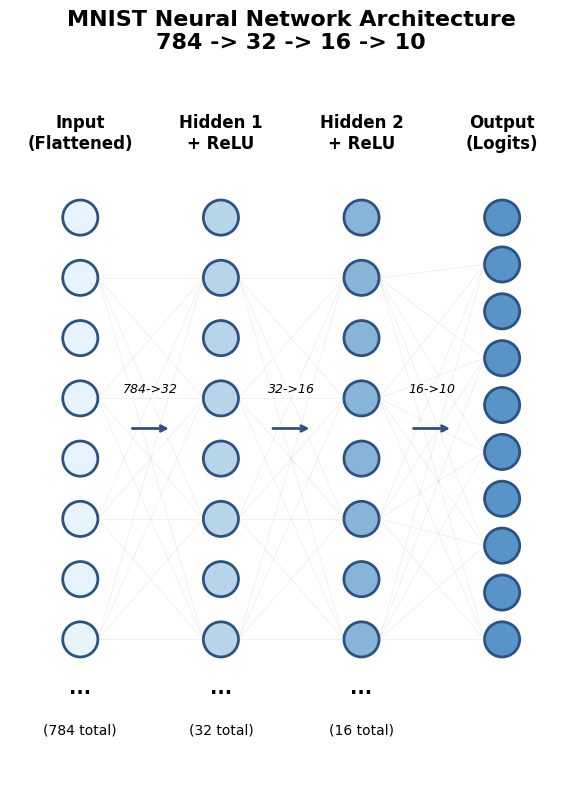

In [5]:
# Visualize the neural network architecture
visualize_network_architecture()

### What does each layer do?

| Layer | What it does |
|-------|--------------|
| **Linear (784 → 32)** | Each of the 32 neurons computes a weighted sum of all 784 input pixels. Think of each neuron as looking for a specific pattern across the entire image - maybe one detects diagonal lines, another looks for curves in the top-left corner. |
| **ReLU** | Applies a simple rule: if the number is negative, make it zero; otherwise keep it. This introduces *non-linearity* - without it, stacking layers would be pointless (multiple linear transformations = one linear transformation). ReLU lets the network learn complex, non-linear patterns. |
| **Linear (32 → 16)** | Combines the 32 pattern detections into 16 higher-level features. These might represent more abstract concepts like "has a loop" or "has a vertical stroke". |
| **ReLU** | Another non-linearity, filtering out negative activations. |
| **Linear (16 → 10)** | The final layer produces 10 numbers (one per digit). The highest value is the network's prediction. |

**Key insight**: Each layer builds on the previous one. Early layers detect simple features (edges, curves), while later layers combine these into abstract concepts (digit shapes). This is the hierarchy we'll try to interpret!

Now we will train the neural network using the dataset. We can control two main parameters during training:
- Epochs: this is how many steps train for
- Learning Rate: this is how much we will choose to change our network every step

**Excerise**: Try to change the parameters and see how this affects how well the neural networks trains. Remember that the lower the loss the better!

Epoch 1/20, Train Loss: 0.5212, Test Loss: 0.2586, Accuracy: 0.9217
Epoch 2/20, Train Loss: 0.2333, Test Loss: 0.2062, Accuracy: 0.9385
Epoch 3/20, Train Loss: 0.1833, Test Loss: 0.1605, Accuracy: 0.9529
Epoch 4/20, Train Loss: 0.1553, Test Loss: 0.1550, Accuracy: 0.9564
Epoch 5/20, Train Loss: 0.1371, Test Loss: 0.1485, Accuracy: 0.9575
Epoch 6/20, Train Loss: 0.1212, Test Loss: 0.1373, Accuracy: 0.9604
Epoch 7/20, Train Loss: 0.1098, Test Loss: 0.1340, Accuracy: 0.9606
Epoch 8/20, Train Loss: 0.1005, Test Loss: 0.1222, Accuracy: 0.9649
Epoch 9/20, Train Loss: 0.0918, Test Loss: 0.1186, Accuracy: 0.9651
Epoch 10/20, Train Loss: 0.0856, Test Loss: 0.1166, Accuracy: 0.9669
Epoch 11/20, Train Loss: 0.0792, Test Loss: 0.1143, Accuracy: 0.9681
Epoch 12/20, Train Loss: 0.0734, Test Loss: 0.1110, Accuracy: 0.9680
Epoch 13/20, Train Loss: 0.0693, Test Loss: 0.1120, Accuracy: 0.9690
Epoch 14/20, Train Loss: 0.0656, Test Loss: 0.1129, Accuracy: 0.9669
Epoch 15/20, Train Loss: 0.0612, Test Loss:

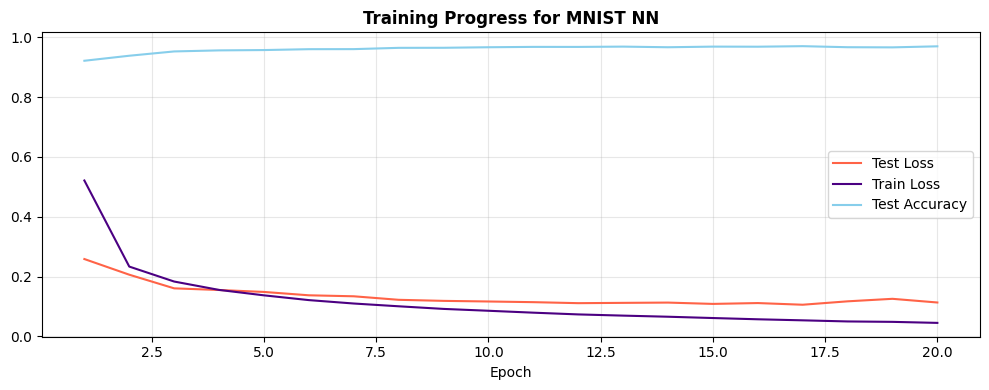

In [6]:
# =============================================================================
# TRAINING PARAMETERS - You can modify these!
# =============================================================================
EPOCHS = 20
LEARNING_RATE = 0.001

# Create and train the model
model = create_model()
optimizer = create_optimizer(model, lr=LEARNING_RATE)
history = train_model(model, optimizer, train_loader, test_loader, epochs=EPOCHS)
# Plot training progress
plot_training_history(history)

### Extracting Predictions from the Model

The final layer of our network outputs 10 numbers - but what do they mean, and how do we turn them into a prediction?

**What are logits?**

The raw output numbers from the last layer are called **logits**. They can be any value (positive, negative, large, small). Think of them as "scores" - the higher the score for a digit, the more confident the network is that the input is that digit.

For example, if the logits are: `[−2.1, 8.5, 0.3, −1.2, 0.1, −0.5, 0.2, 1.1, −0.8, 0.4]`

The network is most confident about digit **1** (score of 8.5) and least confident about digit **0** (score of −2.1).

**From logits to probabilities: the Softmax function**

Logits are hard to interpret - what does a score of 8.5 really mean? We convert them to **probabilities** using the **softmax** function:

$$\text{probability}_i = \frac{e^{\text{logit}_i}}{\sum_j e^{\text{logit}_j}}$$

Softmax does two things:
1. **Exponentiates** each logit (making them all positive)
2. **Normalises** so they sum to 1 (making them valid probabilities)

After softmax, our example becomes: `[0.01%, 99.5%, 0.03%, ...]` - now we can say the network is **99.5% confident** this is a "1".

**Making the final prediction**

The prediction is simply the digit with the highest probability (or equivalently, the highest logit). We pick the **argmax** - the index of the maximum value.

**Why not just use the highest logit directly?** We could! But probabilities are more interpretable and useful for:
- Understanding confidence ("90% sure" vs "51% sure")
- Detecting uncertainty (flat distribution = confused network)
- Training the network (the loss function uses probabilities)

**Excerise**: In the following cell, you can randomly sample a handwritten digit from the dataset and then see what the neural network classifies it as. Try to analyze the output logit distribution to see whats kinds of mistakes the neural network makes and what kinds of digits it gets confused by.

This is always a first step in interpreting neural network. By changing the inputs and obersving the outputs systematically we can figure out what kinds of patterns the network learns.

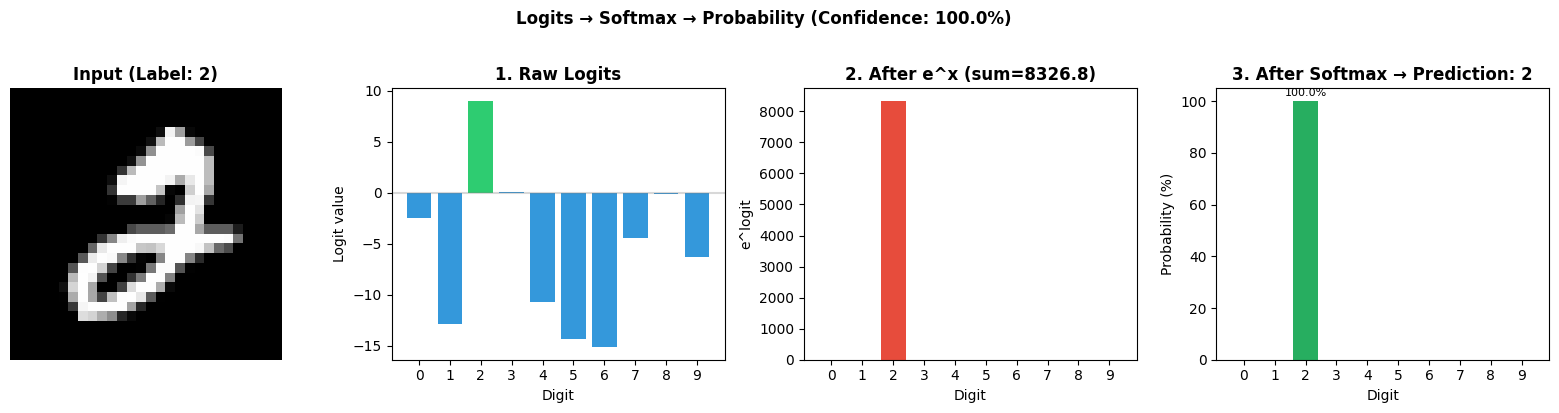

In [7]:
# =============================================================================
# CHOOSE A DIGIT TO VISUALIZE - Change this value!
# =============================================================================
DIGIT_TO_VIEW = 2  # Try values 0-9

# Get a sample of that digit and show its prediction
image, label = get_sample_by_digit(test_images, test_labels, DIGIT_TO_VIEW)
visualize_prediction(model, image, label)

## Understanding Activations

**What are activations?** As data flows through a neural network, each layer transforms the input and produces an output called an "activation". These activations are the intermediate representations the network builds as it processes information. By using the activations as our "data" we can perform statistical investigations on them to understand the neural network. This is the basic thesis of mechanistic interpretability

The higher the activation is in magnitude, the more we can say that the neuron "reacts" to the input it recieves. Another way of thinking about it is that the neuron pays more attention.

**Why do they matter?** By examining activations, we can understand:
- What features each layer has learned to detect
- How the network transforms raw pixels into abstract concepts
- Which neurons "fire" (have high values) for different inputs

Our network has 5 activation points:
- **Layer 0**: After first Linear (784 → 32)
- **Layer 1**: After first ReLU (32 neurons, negative values zeroed)
- **Layer 2**: After second Linear (32 → 16)
- **Layer 3**: After second ReLU (16 neurons)
- **Layer 4**: Output logits (16 → 10)

### Exercise: Exploring Activations

In the cells below, you'll visualise what happens inside the network when it processes different digits.

**Try these investigations:**

1. **Same digit, different samples**: Run the cell multiple times with the same `DIGIT_TO_EXPLORE` value. Do the activations look similar across different examples of the same digit? What stays consistent?

2. **Find "dead" neurons**: After ReLU, some neurons might always be zero. Can you find any? What might this tell us about the network?

**Questions to consider:**
- Do certain neurons seem to "specialise" for certain digits?
- How do the activations change as you move deeper into the network?

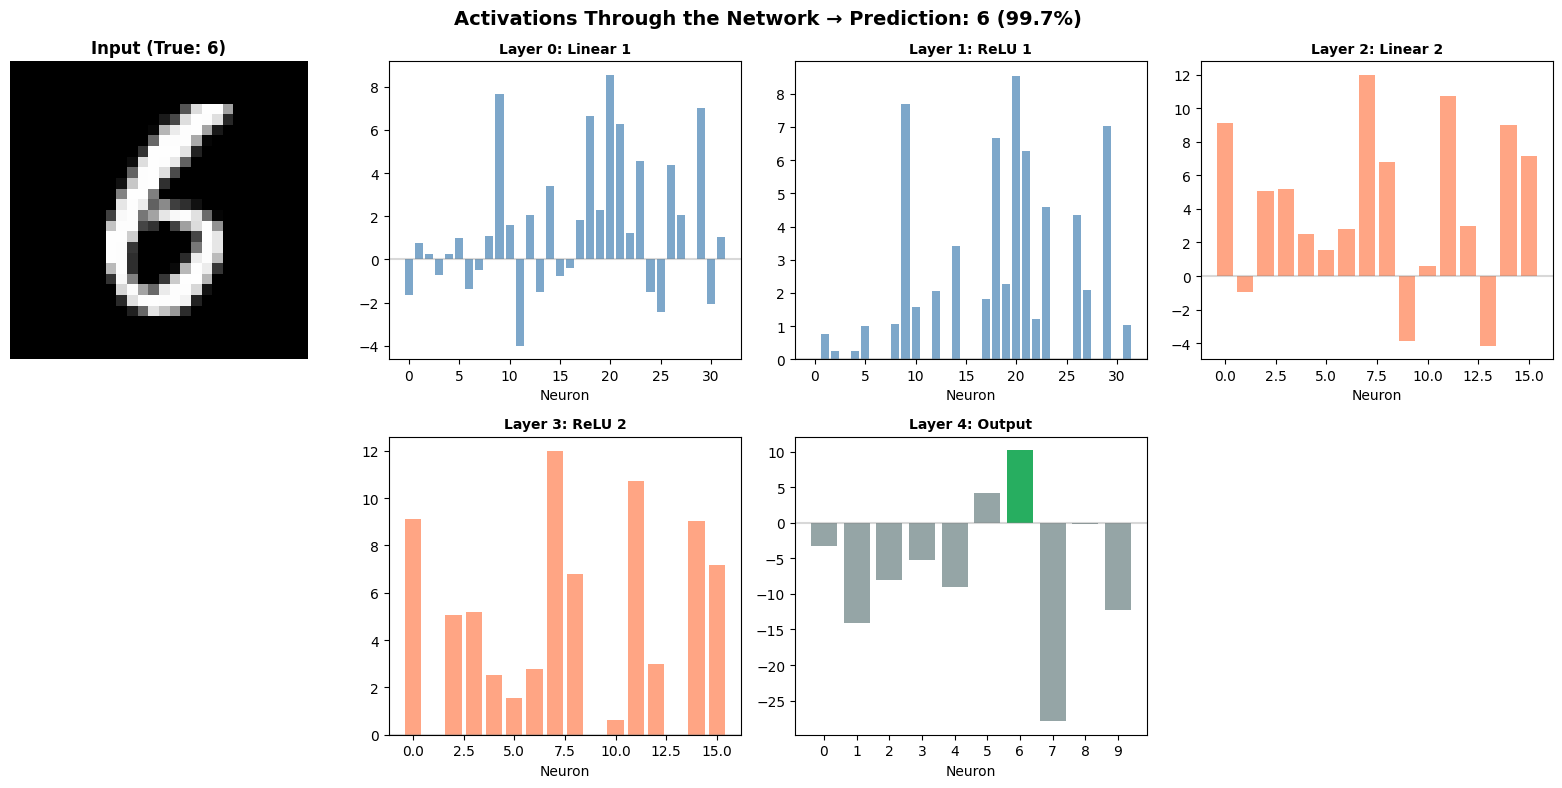

In [18]:
# =============================================================================
# INTERACTIVE ACTIVATION EXPLORER
# =============================================================================
# Choose how to select your input:
#   - By digit (0-9): Shows activations for a sample of that digit

# Select by digit
DIGIT_TO_EXPLORE = 6  # Change this! (0-9)

image, label = get_sample_by_digit(test_images, test_labels, DIGIT_TO_EXPLORE)
plot_activations(model, image, label)

### Exercise: Comparing Activations Between Digits

One of the most powerful ways to understand what a neural network has learned is to **compare** how it processes different inputs. By looking at two digits side-by-side, we can spot:

- **Which neurons respond differently** - these might be the "detectors" for distinguishing features
- **Which neurons respond similarly** - these might detect features common to both digits
- **Where in the network** the distinction emerges - early layers or later layers?

**Suggested comparisons to try:**

| Comparison | What you might discover |
|------------|------------------------|
| **1 vs 8** | Simple vs complex - does "8" activate more neurons? |
| **3 vs 8** | Similar shapes - which neurons tell them apart? |
| **4 vs 9** | Both have a vertical stroke - what's different? |
| **0 vs 6** | Both have loops - how does the network distinguish? |
| **1 vs 7** | Both are "stick-like" - subtle differences |
| **5 vs 6** | Curvy digits - look for curve detectors |

**What to look for:**
1. In the **early layers** (0-1): Are there neurons that activate strongly for one digit but not the other?
2. In the **later layers** (2-3): Do the activation patterns become more distinct?
3. In the **output layer** (4): Can you see why the network makes its prediction?


## Introduction to Probes

We've seen that different digits produce different activation patterns. But can we do more than just *look* at these patterns? Can we *systematically test* whether the network has learned specific concepts?

This is where **probes** come in.


### The Key Insight: Activations as Data

Here's the crucial idea: **we can treat the activations themselves as a new dataset**.

Think about it:
- When we trained the original network, our data was images (784 pixels) and labels (which digit)
- Now, we have a *new* kind of data: the activations the network produces for each image

For every image we feed through the network, we can extract the activations at any layer. These activations are just vectors of numbers - and vectors of numbers can be used as **input features for another classifier**.

---

### What is a Probe?

A **probe** is a simple classifier (usually logistic regression) that we train on the *activations* of a neural network to detect whether a specific concept is represented.

**The Big Picture Analogy**: Imagine you have a friend who's an expert chef. You want to understand how they think about food. You can't read their mind directly, but you *can* ask them simple yes/no questions about dishes:
- "Is this dish spicy?" 
- "Does this need more salt?"
- "Is this a dessert?"

If they can easily answer these questions, it means they're representing these concepts in their head - even if they never explicitly told you they think about "spiciness" or "saltiness."

**Probes work the same way for neural networks!** We ask simple questions about the activations to discover what concepts the network has learned.

---

### The Probe Procedure: Step by Step

**Step 1: Extract Activations**

Feed many images through the neural network and save the activations at a chosen layer. Think of this as "recording what the network is thinking" at a specific point.

**Step 2: Create New Labels Based on a Concept**

We're not interested in "which digit is this?" anymore. We're asking a *different* question - one the network was never trained on! For example: "Does this digit have a loop?"

**Step 3: Train a Simple Classifier (The Probe)**

Now we train logistic regression using:
- **X (inputs)**: The activations we extracted
- **y (targets)**: Our new concept labels (has loop = 1, no loop = 0)

The probe learns weights for each neuron in the layer, essentially asking: "Which neurons activate when there's a loop? Which neurons activate when there's no loop?"

**Step 4: Evaluate**

Test the probe on images it hasn't seen. If it achieves high accuracy, we've discovered something profound: **the network has learned to represent "loop-ness" even though we never asked it to!**


---

### Why Use a *Simple* Classifier?

This is a subtle but important point. We deliberately use logistic regression (a very simple model) rather than a complex neural network for our probe. Why?

**The "Easy Access" Test**: If information is *linearly separable* (can be separated by drawing a straight line/plane), it means the network has organized that information in an easily accessible way.

Think of it like organizing your room:
- **Easily accessible**: Your clothes are in the closet, books on the shelf, electronics on the desk. You can find things quickly.
- **Buried and messy**: Everything is piled in random boxes. The information is technically *there*, but it's hard to extract.

A simple linear probe can only find information that's "organized nicely" in the activations. If a simple probe works, the network has explicitly represented that concept. If only a complex model works, the information might be there but isn't cleanly represented.

---

### What Can Probes Tell Us?

Probes are like a flashlight for peering into the black box. They help us discover:

| Question | What Probe Results Tell Us |
|----------|---------------------------|
| **What concepts did the network learn?** | If a probe for "has loops" works at 90% accuracy, the network learned to represent loop-ness - even though we only trained it on digit labels! |
| **Which layer represents which concepts?** | By probing each layer, we can see where concepts "emerge." Simple features (edges) appear early; complex features (loops, shapes) appear later. |
| **Is information accessible?** | High probe accuracy = information is explicit and organized. Low accuracy = either the info isn't there, or it's encoded in a complex, non-linear way. |
| **What do individual neurons do?** | The probe weights tell us which neurons fire for which concepts. A neuron with high weight for "has loop" might be a loop detector! |

### Why Does This Matter for AI Safety?

Probes are a key tool in **mechanistic interpretability** - the effort to understand what's happening inside AI systems. Here's why this matters:

1. **Finding hidden biases**: A network might learn problematic concepts we didn't intend. Probes can help us discover them.

2. **Verifying safety-relevant features**: We might want to know if a model has learned to represent "this action is harmful" or "this is uncertain." Probes let us check.

3. **Understanding failures**: If a model makes mistakes, probes can help us understand what it was "thinking" - which concepts it was relying on.

4. **Building trust**: The more we understand about what a model has learned, the more confidently we can deploy it (or decide *not* to deploy it).

In the cells below, you'll train your own probes and discover what concepts our digit classifier has secretly learned!


**Example concepts to probe:**
- Digits with loops (0, 6, 8, 9) vs without (1, 2, 3, 4, 5, 7)
- Even vs odd digits
- Any digit pair distinction

In [10]:
# =============================================================================
# EXPERIMENT 1: Probe for "digits with loops"
# =============================================================================
# Digits with loops: 0, 6, 8, 9
# Digits without loops: 1, 2, 3, 4, 5, 7
#
# Try changing these groups to test different concepts!

POSITIVE_DIGITS = [0, 6, 8, 9]  # Digits WITH loops
NEGATIVE_DIGITS = [1, 2, 3, 4, 5, 7]  # Digits WITHOUT loops
LAYER_TO_PROBE = 2  # Which layer to probe (0-4)

probe, accuracy = train_probe(
    model, train_loader, test_loader,
    positive_digits=POSITIVE_DIGITS,
    negative_digits=NEGATIVE_DIGITS,
    layer_num=LAYER_TO_PROBE
)

print(f"\nThe probe can distinguish {POSITIVE_DIGITS} from {NEGATIVE_DIGITS}")
print(f"at layer {LAYER_TO_PROBE} with {accuracy:.1%} accuracy!")

Probe accuracy: 0.8075

The probe can distinguish [0, 6, 8, 9] from [1, 2, 3, 4, 5, 7]
at layer 2 with 80.8% accuracy!


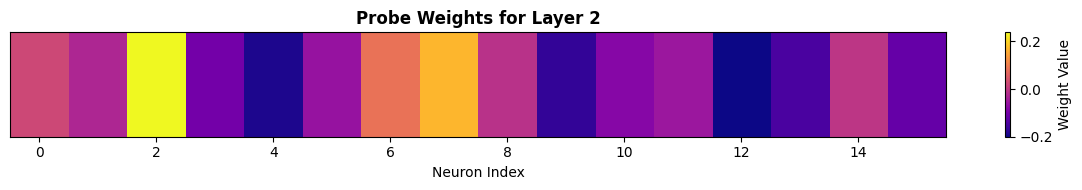

In [11]:
# Visualize what the probe learned (which neurons it relies on)
visualize_probe_weights(probe, title=f"Probe Weights for Layer {LAYER_TO_PROBE}")

### How to Interpret the Probe Weights

The chart above shows the **weights** that the logistic regression probe learned for each neuron. But what do these weights actually mean?

**What the weights tell us:**

| Weight Value | What It Means | Interpretation |
|--------------|---------------|----------------|
| **Large positive** (tall green bar) | When this neuron fires strongly, the probe predicts "positive class" | This neuron is a **detector for the concept** (e.g., detects loops) |
| **Large negative** (tall red bar) | When this neuron fires strongly, the probe predicts "negative class" | This neuron **detects the opposite** (e.g., detects non-loops) |
| **Near zero** (short bar) | This neuron doesn't influence the probe's decision much | This neuron is **irrelevant to this concept** |

**What to look for:**
1. **How many neurons matter?** If only 2-3 neurons have large weights, the concept is encoded sparsely. If many neurons contribute, it's distributed.
2. **Which neurons are strongest?** These are the "main detectors" for this concept.
3. **Balance of positive vs negative:** Are there more "for" detectors or "against" detectors?

Probing: [0, 6, 8, 9] vs [1, 2, 3, 4, 5, 7]

Layer 0 (Linear 1 (32)): Probe accuracy: 0.8103
Layer 1 (ReLU 1 (32)): Probe accuracy: 0.8561
Layer 2 (Linear 2 (16)): Probe accuracy: 0.8362
Layer 3 (ReLU 2 (16)): Probe accuracy: 0.8718
Layer 4 (Output (10)): Probe accuracy: 0.8094


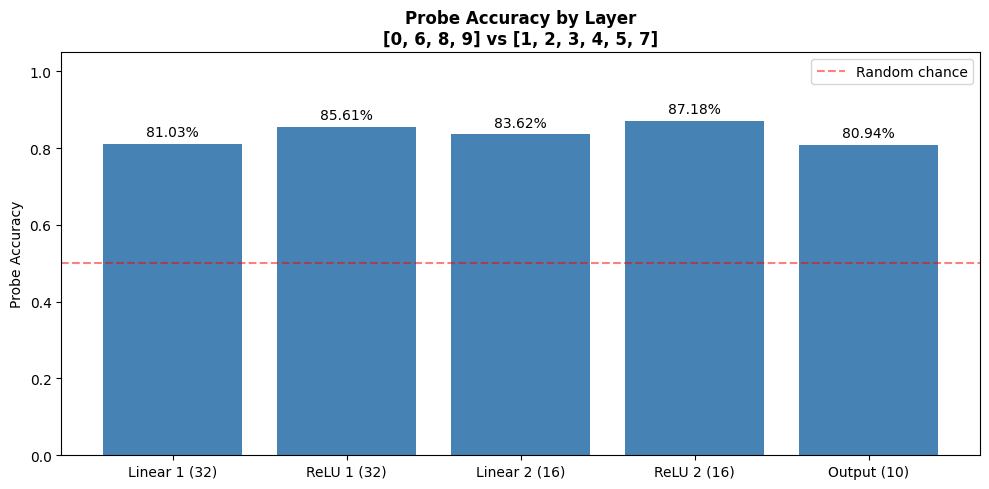

In [12]:
# =============================================================================
# EXPERIMENT 2: Compare probe accuracy across all layers
# =============================================================================
# This shows at which layer the concept becomes most detectable

results = compare_probes_across_layers(
    model, train_loader, test_loader,
    positive_digits=POSITIVE_DIGITS,
    negative_digits=NEGATIVE_DIGITS
)

### How to Interpret the Layer Comparison

The chart above shows probe accuracy at each layer of the network. This tells us **where** in the network a concept is represented - and how that representation evolves as information flows through.

**What does each bar mean?**

Each bar shows how accurately a probe can detect your concept (e.g., "has loop") using *only* the activations from that specific layer. Higher accuracy = the concept is more clearly represented at that layer.

**What to look for:**

1. **Where does the concept "emerge"?** Find the first layer where accuracy jumps significantly above 50% (random chance). This is where the network starts to "know" about the concept.

2. **Where is the concept strongest?** The layer with highest accuracy has the clearest representation of the concept.

3. **Does the output layer care?** If output layer accuracy is high, the concept is directly relevant to classification. If it's low, the concept might be a stepping stone that gets discarded.


**The 50% baseline:** Since we're doing binary classification (yes/no), random guessing would get ~50% accuracy. Any accuracy significantly above 50% means the probe found real information about the concept in those activations.

## Try Your Own Experiments!

Modify the cells below to test different hypotheses about what the network has learned. Change the positive and negative digits to compare digits that have different properties. Investigate how the activations and accuracy changes or does it remain the same? 

In [ ]:
# =============================================================================
# TRY YOUR OWN EXPERIMENT
# =============================================================================

POSITIVE_DIGITS = [0, 2, 4, 6, 8]
NEGATIVE_DIGITS = [1, 3, 5, 7, 9]

probe_even_odd, acc_even_odd = train_probe(
    model, train_loader, test_loader,
    positive_digits=POSITIVE_DIGITS,
    negative_digits=NEGATIVE_DIGITS,
    layer_num=2  # Try different layers!
)

print(f"\nEven vs Odd probe accuracy: {acc_even_odd:.1%}")

Probe accuracy: 0.9065

Even vs Odd probe accuracy: 90.6%


In [ ]:
# Visualize what the probe learned (which neurons it relies on)
visualize_probe_weights(probe, title=f"Probe Weights for Layer {LAYER_TO_PROBE}")

In [ ]:
# Compare probe accuracy across all layers. 
# This shows at which layer the concept becomes most detectable

results = compare_probes_across_layers(
    model, train_loader, test_loader,
    positive_digits=POSITIVE_DIGITS,
    negative_digits=NEGATIVE_DIGITS
)